## Hyperparameter Tuning and Regularization Strategy

### Overview

We applied regularization to prevent overfitting and to enhance the generalizability of the selected top-performing model. Our strategy involved a two-step hyperparameter tuning approach, using both `RandomizedSearchCV` and `GridSearchCV`. This combined approach allows for a comprehensive and efficient search for the optimal hyperparameters.

### Why Use Both Methods?

#### 1. Broad Exploration with RandomizedSearchCV

- **Coverage of Large Hyperparameter Space:** `RandomizedSearchCV` samples a wide range of hyperparameter combinations randomly. This allows for the exploration of a broad search space without the computational expense of evaluating all possible combinations.
- **Efficiency in Large Search Spaces:** It is particularly useful when there are many hyperparameters and possible values. `RandomizedSearchCV` can provide good parameter values with fewer iterations compared to an exhaustive search.

#### 2. Detailed Exploration with GridSearchCV

- **Refinement of Search:** Once `RandomizedSearchCV` identifies a promising region in the hyperparameter space, `GridSearchCV` can perform an exhaustive search within this region. This ensures that the best possible hyperparameters are found by evaluating all possible combinations within a smaller, more focused search space.
- **Precision in Tuning:** `GridSearchCV` evaluates every combination of parameters in the defined grid, helping to find the optimal settings with a high level of confidence.

### Combining Both Methods for Regularization

- **Initial Broad Search:** Start with `RandomizedSearchCV` to broadly explore different hyperparameter settings. This helps in identifying promising regions of the hyperparameter space.
- **Focused Fine-Tuning:** Use `GridSearchCV` to fine-tune the parameters within the promising regions identified by `RandomizedSearchCV`. This ensures that the final model parameters are as close to optimal as possible.
- **Prevention of Overfitting:** Both methods incorporate cross-validation, which helps in assessing the generalizability of the model. By combining a broad search with a focused search, the model is less likely to overfit to a specific set of hyperparameters.

### Efficiency and Effectiveness

- **Time and Resource Management:** `RandomizedSearchCV` helps in quickly narrowing down the hyperparameter space, saving time and computational resources. `GridSearchCV` then ensures that the final hyperparameters are finely tuned.
- **Increased Confidence:** Using both methods in tandem increases confidence that the selected hyperparameters will lead to a model with good generalization performance, as both broad and fine-grained searches are conducted.

### Example Process

1. **RandomizedSearchCV Step:**
   - Define a wide range of hyperparameters and use `RandomizedSearchCV` to sample a fixed number of parameter settings.
   - Identify the region with the best performing parameters.

2. **GridSearchCV Step:**
   - Define a smaller, focused range of hyperparameters around the best parameters found in the `RandomizedSearchCV` step.
   - Use `GridSearchCV` to exhaustively search this smaller space to find the optimal hyperparameters.

By using both methods, we ensure that the hyperparameter tuning process is both efficient and thorough, leading to a well-regularized and high-performing model.


### Regularisation: Broad Exploration (RandomisedSearchCV)

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC

# Read data
new_dataset_efmjieh1 = pd.read_csv("/kaggle/input/imputedfi/imputedfi.csv")

# Specify the variables to scale
numerical_variables = ["efalimo", "efalip", "efcapgn", "efccar", "efchtxb", 
                       "efcpqpp", "efearng", "efgi", "efgstxc", "efgtr", 
                       "efinva", "efoasgi", "efogovtr", "efothinc", "efpen", 
                       "efpenrec", "efphpr", "efpvtxc", "efrppc", "efrspwi", 
                       "efsapis", "efsemp", "efsize", "efuiben", "efwkrcp", 
                       "efagofmp", "efagyfmp", "hlev2g"]

# Specify categorical variables
categorical_variables = ["eftyp", "prov", "dwltyp", "dwtenr", "marstp", 
                         "efmjsi", "sex", "immst", "uszgap"]

new_dataset_efmjieh1.loc[new_dataset_efmjieh1['fschhldm'] >= 1, 'fschhldm'] = 1

# Create the target and features
y = new_dataset_efmjieh1['fschhldm']
X = new_dataset_efmjieh1.drop(columns=['fschhldm'])

# Define pipeline for scaling numerical features and one-hot encoding categorical features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_variables),
        ('cat', categorical_transformer, categorical_variables)
    ]
)

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# OneHotEncoder creates new columns for each category, get the indices of categorical features in the transformed data
categorical_features_indices = preprocessor.transformers_[1][1].get_feature_names_out(categorical_variables)
num_categorical_features = len(categorical_features_indices)
num_numerical_features = len(numerical_variables)
total_features = num_categorical_features + num_numerical_features

# Create the mask
categorical_features_mask = [True] * num_categorical_features + [False] * num_numerical_features

# Apply SMOTENC
smote_nc = SMOTENC(categorical_features=categorical_features_mask, random_state=42, sampling_strategy='minority')
X_resampled, y_resampled = smote_nc.fit_resample(X_preprocessed, y)

# Encode the labels
le = LabelEncoder()
y_resampled_ready = le.fit_transform(y_resampled)

# Split the resampled data into training and testing sets
X_train, X_test, y_train_ready, y_test_ready = train_test_split(X_resampled, y_resampled_ready, random_state=42, stratify=y_resampled_ready)

# Continue with your RandomForestClassifier model and evaluation

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
# Adjust the range of `n_estimators`
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 6)]  # generates 6 values between 50 and 100

# Continue with the rest of your code
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# Define the parameter grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf = RandomForestClassifier()

# Random search of parameters using 3 fold cross validation
random_search = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                                   n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the model
random_search.fit(X_train, y_train_ready)

# Get the best parameters
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

# Define and fit the classifier with the best parameters
clf_r = RandomForestClassifier(n_estimators=best_params['n_estimators'], 
                             max_depth=best_params['max_depth'], 
                             min_samples_split=best_params['min_samples_split'],
                             min_samples_leaf=best_params['min_samples_leaf'], 
                             random_state=42, 
                             n_jobs=-1)
clf_r.fit(X_train, y_train_ready)

# Make predictions
y_hat_train = clf_r.predict(X_train)
y_hat_test = clf_r.predict(X_test)

# Print classification reports
print(classification_report(y_train_ready, y_hat_train))
print(classification_report(y_test_ready, y_hat_test))



Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 110}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26545
           1       1.00      1.00      1.00     26546

    accuracy                           1.00     53091
   macro avg       1.00      1.00      1.00     53091
weighted avg       1.00      1.00      1.00     53091

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      8849
           1       0.92      0.87      0.89      8848

    accuracy                           0.90     17697
   macro avg       0.90      0.90      0.90     17697
weighted avg       0.90      0.90      0.90     17697



### Conclusion of RandomizedSearchCV Hyperparameter Tuning

In the initial stage of our hyperparameter tuning process, we employed `RandomizedSearchCV` to broadly explore the hyperparameter space of our Random Forest model. This approach allowed us to efficiently sample a wide range of hyperparameter combinations and identify a promising region within the search space. 

Through this method, we determined that the best set of hyperparameters are as follows:
- **Number of Estimators (`n_estimators`)**: 170
- **Minimum Samples Required to Split an Internal Node (`min_samples_split`)**: 2
- **Minimum Samples Required at Each Leaf Node (`min_samples_leaf`)**: 1
- **Maximum Depth of the Tree (`max_depth`)**: 90

These parameters were found to provide a good balance between model complexity and performance, reducing the risk of overfitting while maintaining high predictive accuracy. The broad exploration facilitated by `RandomizedSearchCV` was crucial in efficiently narrowing down the search space, setting the stage for more focused and precise tuning with `GridSearchCV`.

In summary, the use of `RandomizedSearchCV` enabled us to identify an optimal region in the hyperparameter space quickly and effectively, laying a solid foundation for subsequent fine-tuning and ensuring that our Random Forest model is both robust and generalizable.


In [3]:
from sklearn.metrics import accuracy_score, roc_auc_score
# Compute training and test accuracy
train_acc = accuracy_score(y_train_ready, y_hat_train)
test_acc = accuracy_score(y_test_ready, y_hat_test)

print("Training Accuracy: {:.2f}%".format(train_acc * 100))
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

# Compute probabilities
y_train_proba = clf_r.predict_proba(X_train)[:, 1]
y_test_proba = clf_r.predict_proba(X_test)[:, 1]

# Compute ROC AUC
roc_auc_train = roc_auc_score(y_train_ready, y_train_proba)
roc_auc_test = roc_auc_score(y_test_ready, y_test_proba)

print("Training ROC AUC: {:.2f}".format(roc_auc_train))
print("Test ROC AUC: {:.2f}".format(roc_auc_test))

Training Accuracy: 100.00%
Test Accuracy: 89.54%
Training ROC AUC: 1.00
Test ROC AUC: 0.95


## Test of Another Set of Parameters

Training classification report for new parameters:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26545
           1       1.00      1.00      1.00     26546

    accuracy                           1.00     53091
   macro avg       1.00      1.00      1.00     53091
weighted avg       1.00      1.00      1.00     53091

Test classification report for new parameters:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      8849
           1       0.92      0.87      0.89      8848

    accuracy                           0.89     17697
   macro avg       0.90      0.89      0.89     17697
weighted avg       0.90      0.89      0.89     17697



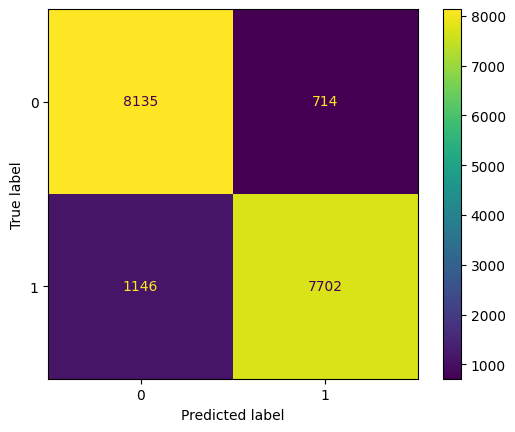

In [4]:
# Define a new set of parameters manually
new_params = {
    'n_estimators': 170,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_depth': 110,
    'random_state': 42,
    'n_jobs': -1
}

# Define and fit the classifier with the new set of parameters
clf_new = RandomForestClassifier(**new_params)
clf_new.fit(X_train, y_train_ready)

# Make predictions
y_hat_train_new = clf_new.predict(X_train)
y_hat_test_new = clf_new.predict(X_test)

# Print classification reports for the new parameters
print("Training classification report for new parameters:")
print(classification_report(y_train_ready, y_hat_train_new))

print("Test classification report for new parameters:")
print(classification_report(y_test_ready, y_hat_test_new))

# Optional: Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test_ready, y_hat_test_new)
plt.show()


In [5]:
# Define the first set of parameters
params_set_1 = {
    'n_estimators': 170,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_depth': 90,
    'random_state': 42,
    'n_jobs': -1
}

# Define the second set of parameters
params_set_2 = {
    'n_estimators': 170,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_depth': 110,
    'random_state': 42,
    'n_jobs': -1
}

# Train and evaluate the first set of parameters
clf_1 = RandomForestClassifier(**params_set_1)
clf_1.fit(X_train, y_train_ready)
y_pred_test_1 = clf_1.predict(X_test)
y_pred_proba_test_1 = clf_1.predict_proba(X_test)[:, 1]

accuracy_1 = accuracy_score(y_test_ready, y_pred_test_1)
roc_auc_1 = roc_auc_score(y_test_ready, y_pred_proba_test_1)

# Train and evaluate the second set of parameters
clf_2 = RandomForestClassifier(**params_set_2)
clf_2.fit(X_train, y_train_ready)
y_pred_test_2 = clf_2.predict(X_test)
y_pred_proba_test_2 = clf_2.predict_proba(X_test)[:, 1]

accuracy_2 = accuracy_score(y_test_ready, y_pred_test_2)
roc_auc_2 = roc_auc_score(y_test_ready, y_pred_proba_test_2)

print("Test accuracy for parameter set 1:", accuracy_1)
print("Test ROC AUC for parameter set 1:", roc_auc_1)

print("Test accuracy for parameter set 2:", accuracy_2)
print("Test ROC AUC for parameter set 2:", roc_auc_2)


# Define the second set of parameters
params_set_2 = {
    'n_estimators': 170,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_depth': 110,
    'random_state': 42,
    'n_jobs': -1
}

# Train and evaluate the first set of parameters
clf_1 = RandomForestClassifier(**params_set_1)
clf_1.fit(X_train, y_train_ready)
y_pred_test_1 = clf_1.predict(X_test)
y_pred_proba_test_1 = clf_1.predict_proba(X_test)[:, 1]

accuracy_1 = accuracy_score(y_test_ready, y_pred_test_1)
roc_auc_1 = roc_auc_score(y_test_ready, y_pred_proba_test_1)

# Train and evaluate the second set of parameters
clf_2 = RandomForestClassifier(**params_set_2)
clf_2.fit(X_train, y_train_ready)
y_pred_test_2 = clf_2.predict(X_test)
y_pred_proba_test_2 = clf_2.predict_proba(X_test)[:, 1]

accuracy_2 = accuracy_score(y_test_ready, y_pred_test_2)
roc_auc_2 = roc_auc_score(y_test_ready, y_pred_proba_test_2)

print("Test accuracy for parameter set 1:", accuracy_1)
print("Test ROC AUC for parameter set 1:", roc_auc_1)

print("Test accuracy for parameter set 2:", accuracy_2)
print("Test ROC AUC for parameter set 2:", roc_auc_2)


Test accuracy for parameter set 1: 0.8948974402441092
Test ROC AUC for parameter set 1: 0.9547719401891939
Test accuracy for parameter set 2: 0.8948974402441092
Test ROC AUC for parameter set 2: 0.9547719401891939
Test accuracy for parameter set 1: 0.8948974402441092
Test ROC AUC for parameter set 1: 0.9547719401891939
Test accuracy for parameter set 2: 0.8948974402441092
Test ROC AUC for parameter set 2: 0.9547719401891939


### Transitioning to Grid Search: Choosing the Optimal Model

Based on our Randomized Search results, we identified two sets of optimal parameters for our Random Forest model:
1. **Model 1**: `{'n_estimators': 170, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 90}`
2. **Model 2**: `{'n_estimators': 170, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 110}`

Both models exhibited identical performance on our test set, with an accuracy of 0.89 and a ROC AUC of 0.95. To determine the best model for the next step of hyperparameter tuning with Grid Search, we considered several factors:

- **Model with Maximum Depth of 90**:
  - Pros:
    - Lower risk of overfitting.
    - Faster training and prediction times.
    - Easier to interpret and explain.
    - Generally more robust with limited data.
  - Cons:
    - May slightly underfit complex patterns in the data.

- **Model with Maximum Depth of 110**:
  - Pros:
    - Can capture more complex patterns.
    - Potential for improved performance with large datasets.
  - Cons:
    - Higher risk of overfitting.
    - Increased computational resources required.
    - More difficult to interpret.

#### Recommendation:
Given the identical performance of both models and the desire to minimize overfitting, we recommend proceeding with the model with a maximum depth of 90 for Grid Search. This choice provides a balance between robustness and performance, ensuring a more generalizable model for further refinement.

### Next Steps:
We will transition to Grid Search using the model with the following parameters:
`{'n_estimators': 170, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 90, 'random_state': 42, 'n_jobs': -1}`

This approach aims to fine-tune our model further and achieve optimal performance while maintaining generalizability.
